# Contextual Bandits for Count Data

Let's look at how UCB can be used to make the exploit-explore tradeoff for another plausible business problem.

### Maximizing Web Storefront Transactions per Week

Imagine we have a web storefront for which we want to maximize transactions per week. To do so, our design team has come up with a new layout that they claim will be more effective, but will it? This is an example of a two-armed bandit, but in contrast to the Bernoulli bandit, we are trying to maximize a count variable. 

Mathematically speaking, we will receive a count reward with the form $\textrm{Reward}_k \sim \textrm{Poisson}(\lambda _k)$.

### Simulating the Problem

We'll create a blackbox `VisitorOracle` class that represents the transaction information we get from our storefront at the end of each week. We'll again intentionally set it up such that the new action has a small but real lift over the status quo.

In [1]:
from typing import List
import numpy as np

class VisitorOracle:

    def __init__(self, n: float, m: float):
        self.n = n
        self.m = m

        self.rewards: List[int] = []

    def status_quo_action(self):
        self.rewards.append(np.random.poisson(self.n))

    def new_proposal_action(self):
        self.rewards.append(np.random.poisson(self.m))

two_armed_bandit = VisitorOracle(20, 25)

### Setting up the learner

`bayesianbandits` makes a `GammaRegressor` class available to perform conjugate prior Bayesian inference on count data. This time, we'll use a fairly informative prior - presumably, we have plenty of knowledge about historical transaction data for our storefront, so we'd be able to use that to pick a reasonable prior. 

In [2]:
from bayesianbandits import GammaRegressor

est = GammaRegressor(alpha = 20, beta = 1)


Next, we define our action structure and reward functions:

In [3]:
from enum import Enum


class VisitorActions(Enum):
    STATUS_QUO = 0
    NEW_PROPOSAL = 1

    def take_action(self, visitor: VisitorOracle):
        if self == VisitorActions.STATUS_QUO:
            visitor.status_quo_action()
        elif self == VisitorActions.NEW_PROPOSAL:
            visitor.new_proposal_action()



def reward_func(x: np.float_) -> np.float_:
    return x

And finally, our `Agent` class. This time, we'll be using the `upper_confidence_bound` algorithm, which uses the upper bound of a credible interval to pick which arm to pull. Somewhat arbitrarily, we'll pick a one-sided 84% credible interval, which corresponds roughly to a $\mu + \sigma$ interval, given a normally-distributed posterior. 

In [4]:
from bayesianbandits import Bandit, upper_confidence_bound, Arm

class Agent(Bandit, learner=est, policy=upper_confidence_bound(0.84)):
    status_quo_arm = Arm(VisitorActions(0), reward_func)
    new_proposal_arm = Arm(VisitorActions(1), reward_func)

agent = Agent()

Now, let's simulate some learning. We'll say we want to run this experiment for a quarter, or 13 weeks.

In [5]:
for _ in range(13):
    action_token: VisitorActions = agent.pull()
    action_token.take_action(two_armed_bandit)
    agent.update(two_armed_bandit.rewards[-1])

Indeed, we see that our agent identifies the new proposed arm as the better option and spent more time pulling it. 

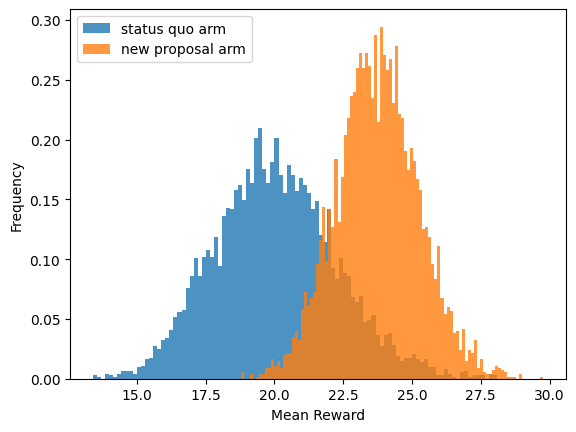

In [6]:
import matplotlib.pyplot as plt

plt.hist(
    agent.status_quo_arm.sample(np.array([[1]]), size=5000),
    alpha=0.8,
    label="status quo arm",
    density=True,
    stacked=True,
    bins=100
)
plt.hist(
    agent.new_proposal_arm.sample(np.array([[1]]), size=5000),
    alpha=0.8,
    label="new proposal arm",
    density=True,
    stacked=True,
    bins=100
)

plt.xlabel("Mean Reward")
plt.ylabel("Frequency")

plt.legend()

plt.show()


As happy as we might be about the above results, our happiness is dashed when our marketing team comes to us with brand-new market research suggesting that our customers actually fall into two major demographics, each of which may have a different reaction to our proposed website layouts. This is an example of a contextual multi-armed bandit problem - in addition to being presented with a choice, we get some information about the choice we'd like to incorporate into our decision making.

Fortunately, `bayesianbandits` can handle contextual bandits with the `@contextual` decorator.

In [7]:
from bayesianbandits import contextual

contextual_bandit = VisitorOracle(20, 25)

@contextual
class Agent(Bandit, learner=est, policy=upper_confidence_bound(0.84)):
    status_quo_arm = Arm(VisitorActions(0), reward_func)
    new_proposal_arm = Arm(VisitorActions(1), reward_func)

context_aware_agent = Agent()

This time, let's say that the `X = 1` demographic has a positive reaction to our proposed layout, but the `X = 0` demographic reacts negatively. By giving the context information to the agent during the `pull` and `update` phases, it will learn which action works best in each context.

Let's simulate another year of data.

In [8]:
for _ in range(52):

    X = np.random.randint(0, 2)
    
    if X == 1:
        contextual_bandit.n = 20
        contextual_bandit.m = 25
    else:
        contextual_bandit.n = 20
        contextual_bandit.m = 18

    action: VisitorActions = context_aware_agent.pull(X)
    action.take_action(contextual_bandit)
    context_aware_agent.update(X, contextual_bandit.rewards[-1])



By plotting what our Agent has learned about each arm, we can see that it has correctly identified that in context 0, the status quo arm is most rewarding, while in context 1, the new proposed arm is most rewarding. 

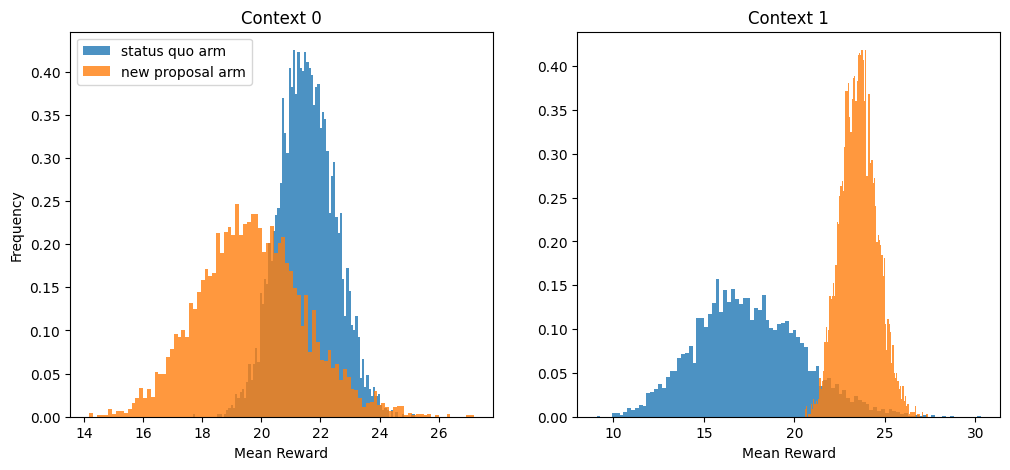

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].hist(
    context_aware_agent.status_quo_arm.sample(np.array([[0]]), size=5000),
    alpha=0.8,
    label="status quo arm",
    density=True,
    stacked=True,
    bins=100
)
ax[0].hist(
    context_aware_agent.new_proposal_arm.sample(np.array([[0]]), size=5000),
    alpha=0.8,
    label="new proposal arm",
    density=True,
    stacked=True,
    bins=100
)

ax[0].set_xlabel("Mean Reward")
ax[0].set_ylabel("Frequency")
ax[0].set_title("Context 0")

ax[0].legend()

ax[1].hist(
    context_aware_agent.status_quo_arm.sample(np.array([[1]]), size=5000),
    alpha=0.8,
    label="status quo arm",
    density=True,
    stacked=True,
    bins=100
)
ax[1].hist(
    context_aware_agent.new_proposal_arm.sample(np.array([[1]]), size=5000),
    alpha=0.8,
    label="new proposal arm",
    density=True,
    stacked=True,
    bins=100
)

ax[1].set_xlabel("Mean Reward")
ax[1].set_title("Context 1")

plt.show()